In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import IPython.display as ipd
import timm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import os
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import folium
from folium.plugins import HeatMap
import librosa
from IPython.display import Audio

/Users/dominik/venv/ml2_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/train_metadata.csv")

In [54]:
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


<h3> Creating barplots <h3>

In [ ]:
plt.figure(figsize=(24, 8))
most_common_names = df["common_name"].value_counts().nlargest(40).index
barplot_data = df[df["common_name"].isin(most_common_names)]
common_name_counts = barplot_data["common_name"].value_counts().sort_values(ascending=False)

sns.barplot(x=common_name_counts.index, y=common_name_counts.values, palette="magma")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of the species of most frequent birds", fontsize=16)
plt.xlabel("Name", fontsize=14)
plt.ylabel('Count', fontsize=14)

In [ ]:
plt.figure(figsize=(24, 8))
least_common_names = df["common_name"].value_counts().nsmallest(40).index
barplot_data = df[df["common_name"].isin(least_common_names)]
common_name_counts = barplot_data["common_name"].value_counts().sort_values(ascending=False)

sns.barplot(x=common_name_counts.index, y=common_name_counts.values, palette="magma")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of the species of least frequent birds", fontsize=16)
plt.xlabel("Name", fontsize=14)
plt.ylabel("Count", fontsize=14)

<h3> Creating heatmap and pointer map <h3>

In [ ]:
map_data = df.dropna(subset=["latitude", "longitude"])
center_lat = map_data["latitude"].mean()
center_lon = map_data["longitude"].mean()

In [ ]:
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=2)
heat_data = [[row["latitude"], row["longitude"]] for index, row in map_data.iterrows()]
heatmap = HeatMap(heat_data, radius=8, blur=0.5, max_zoom=0, opacity=0.3).add_to(my_map)
heatmap.save("../plots/birds_heatmap.html")

In [ ]:
my_map_marker = folium.Map(location=[center_lat, center_lon], zoom_start=2)
for index, row in map_data.iloc[::4].iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="purple",
        fill=True,
        fill_color="purple",
        fill_opacity=0.7,
    ).add_to(my_map_marker)
my_map_marker.save("../plots/birds_markers.html")

<h3> Plotting waveforms <h3>

In [ ]:
filename_1 = "../data/train_audio/abethr1/XC531557.ogg"
filename_2 = "../data/train_audio/blcapa2/XC120191.ogg"

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(filename_1)
sns.lineplot(
    x=np.arange(len(signal_1[0, :].detach().numpy())),
    y=signal_1[0, :].detach().numpy(),
    ax=ax[0],
    color="#F2C36B",
)
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(filename_2)
sns.lineplot(
    x=np.arange(len(signal_2[0, :].detach().numpy())),
    y=signal_2[0, :].detach().numpy(),
    ax=ax[1],
    color="#F2C36B",
)
ax[1].set_title("Audio 2")

plt.show()

<h3> Plotting spectrograms <h3>

In [14]:
def visualize_duplicate_audio(file1, file2):
    path = "../data/train_audio/"
    filename1 = path + file1
    filename2 = path + file2

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    y1, sr1 = librosa.load(filename1)
    spec1 = librosa.display.specshow(
        librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128, fmax=8000)),
        y_axis="mel",
        fmax=8000,
        x_axis="time",
        ax=axs[0],
    )
    print(spec1)

    axs[0].set_title(f'Mel-Spectrogram | file: {filename1.split("/")[-1]}')
    plt.colorbar(spec1, format="%+2.0f dB", ax=axs[0])

    y2, sr2 = librosa.load(filename2)
    spec2 = librosa.display.specshow(
        librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128, fmax=8000)),
        y_axis="mel",
        fmax=8000,
        x_axis="time",
        ax=axs[1],
    )

    axs[1].set_title(f'Mel-Spectrogram | file: {filename2.split("/")[-1]}')
    plt.colorbar(spec2, format="%+2.0f dB", ax=axs[1])

    print(" " * 5, filename1.split("audio")[1])
    display(Audio(filename1))
    print(" " * 5, filename2.split("audio")[1])
    display(Audio(filename2))

    plt.show()

[[-51.34178     -6.7899456    6.97748    ...   7.66179      3.927165
   -7.4866667 ]
 [-51.34178     -9.794351     0.5639177  ...  -5.659789    -5.5238695
  -11.766693  ]
 [-51.34178    -15.402109     0.11462025 ...  -3.4875536   -2.2503457
  -11.8890705 ]
 ...
 [-51.34178    -39.291653   -29.877995   ... -27.385752   -24.854683
  -29.030094  ]
 [-51.34178    -39.985115   -29.887571   ... -29.002487   -29.29499
  -33.121605  ]
 [-51.34178    -41.80345    -32.074997   ... -27.561455   -29.294117
  -35.472492  ]]
      /blnmou1/XC18470.ogg


      /afrgos1/XC115984.ogg


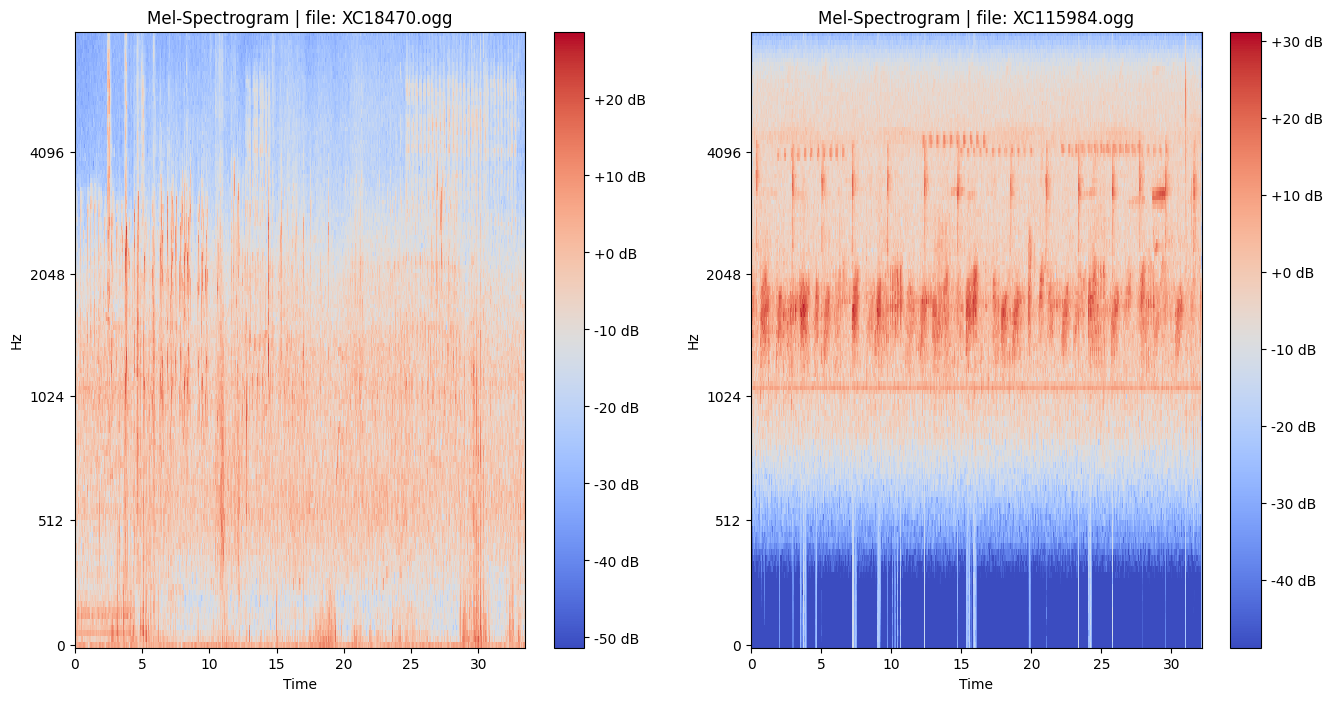

In [15]:
visualize_duplicate_audio("blnmou1/XC18470.ogg", "afrgos1/XC115984.ogg")

In [ ]:
visualize_duplicate_audio("rerswa1/XC133800.ogg", "cohmar1/XC25835.ogg")

<h3> Plotting average duration of recording <h3>

In [ ]:
plt.figure(figsize=(24, 8))
sns.violinplot(x=df["rating"], palette="viridis")

In [ ]:
values_rating_ordered = df["rating"].value_counts().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(24, 8))
sns.barplot(x=values_rating_ordered.index, y=values_rating_ordered.values, color="#F2C36B")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Amount of specific rating values")